In [38]:
# rna_seq_clustering.py
import sys
#!{sys.executable} -m pip install scikit-fuzzy
#!conda install --yes --prefix {sys.prefix} pydeseq2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import scipy
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import gridspec
import skfuzzy as fuzz
#

In [52]:
if True:
     # ---------------------------------------------
    # 1.bis Load Already Processed Data
    # ---------------------------------------------
    normalized_counts = pd.read_csv(r"log_norm_counts.csv", index_col=0)
else:
    from pydeseq2.dds import DeseqDataSet
    # ---------------------------------------------
    # 1. Load Raw Count Data
    # ---------------------------------------------
    file_path = r"raw_counts_all_samples.tsv"
    df = pd.read_csv(file_path, sep='\t', index_col=0)
    
    # Select columns with "Control" in their names
    control_columns = [col for col in df.columns if "Control" in col]
    df_control = df[control_columns]
    
    # ---------------------------------------------
    # 2. Prepare Metadata and Normalize with PyDESeq2
    # ---------------------------------------------
    sample_names = df_control.columns.tolist()
    conditions = [0]*4 + [1]*4 + [2]*4 + [3]*4 + [4]*4  # assuming 5 conditions × 4 replicates
    
    metadata = pd.DataFrame({"condition": conditions}, index=sample_names)
    counts = df_control.T.values  # Transpose to samples x genes
    
    dds = DeseqDataSet(counts=counts, metadata=metadata, design_factors="condition", ref_level="Control")
    dds.fit_size_factors()
    size_factors = dds.obsm["size_factors"]
    
    # Normalize and log-transform
    normalized_counts = df_control.div(size_factors, axis=1)
    log_norm_counts = np.log2(normalized_counts + 1)

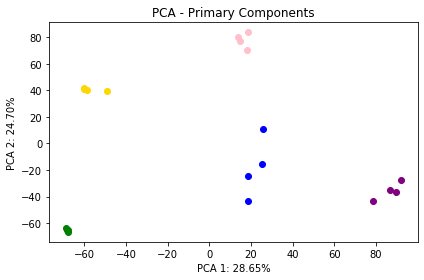

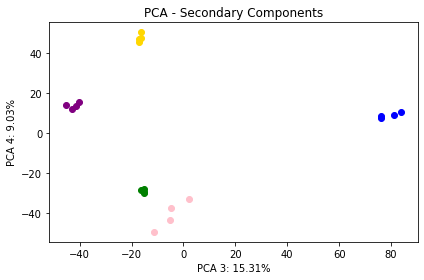

In [54]:
# ---------------------------------------------
# 3. PCA Analysis (Figure 1.C)
# ---------------------------------------------
pca = PCA(n_components=4)
pca_components = pca.fit_transform(normalized_counts.T)

colors = ['blue', 'green', 'gold', 'pink', 'purple']

# Plot primary PCA dimensions
plt.figure()
for j in range(0, len(pca_components), 4):
    for i in range(4):
        plt.plot(pca_components[i + j, 0], pca_components[i + j, 1], 'o', color=colors[j // 4])
plt.xlabel(f"PCA 1: {pca.explained_variance_ratio_[0]*100:.2f}%")
plt.ylabel(f"PCA 2: {pca.explained_variance_ratio_[1]*100:.2f}%")
plt.title("PCA - Primary Components")
plt.tight_layout()
plt.show()

# Plot secondary PCA dimensions
plt.figure()
for j in range(0, len(pca_components), 4):
    for i in range(4):
        plt.plot(pca_components[i + j, 2], pca_components[i + j, 3], 'o', color=colors[j // 4])
plt.xlabel(f"PCA 3: {pca.explained_variance_ratio_[2]*100:.2f}%")
plt.ylabel(f"PCA 4: {pca.explained_variance_ratio_[3]*100:.2f}%")
plt.title("PCA - Secondary Components")
plt.tight_layout()
plt.show()


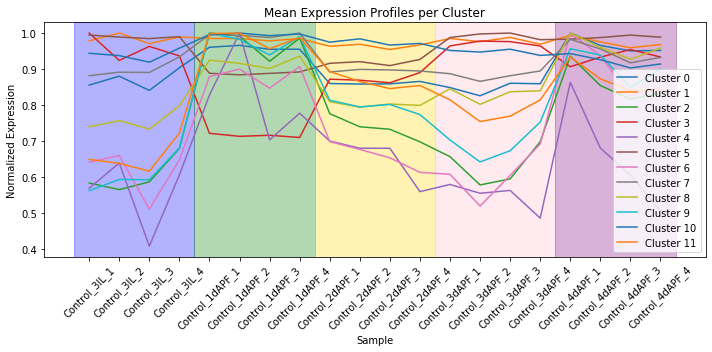

In [74]:
# ---------------------------------------------
# 4. Fuzzy C-Means Clustering (Figure 1.D)
# ---------------------------------------------
X = normalized_counts.T  # genes x samples
n_clusters = 12
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data=X,
    c=n_clusters,
    m=2.0,
    error=0.005,
    maxiter=1000,
    seed=0
)

gene_cluster_labels = np.argmax(u, axis=0)
clustered_df = normalized_counts.copy()
clustered_df["Cluster"] = gene_cluster_labels

# Plot average expression profile per cluster
heatmap_matrix = []
plt.figure(figsize=(10, 5))

# Add shaded regions for each group of 4 samples
num_groups = len(normalized_counts.columns) // 4

for i in range(num_groups):
    plt.axvspan(i*4 - 0.5, (i+1)*4 - 0.5, color=colors[i], alpha=0.3)


for i in range(n_clusters):
    cluster_genes = clustered_df[clustered_df["Cluster"] == i].drop("Cluster", axis=1)
    mean_profile = cluster_genes.mean(axis=0)
    scaled_profile = mean_profile / mean_profile.max()
    plt.plot(scaled_profile, label=f"Cluster {i}")
    heatmap_matrix.append(scaled_profile)

plt.title("Mean Expression Profiles per Cluster")
plt.xlabel("Sample")
plt.ylabel("Normalized Expression")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



C:\Users\eleon\.conda\envs\Classification\lib\site-packages\ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


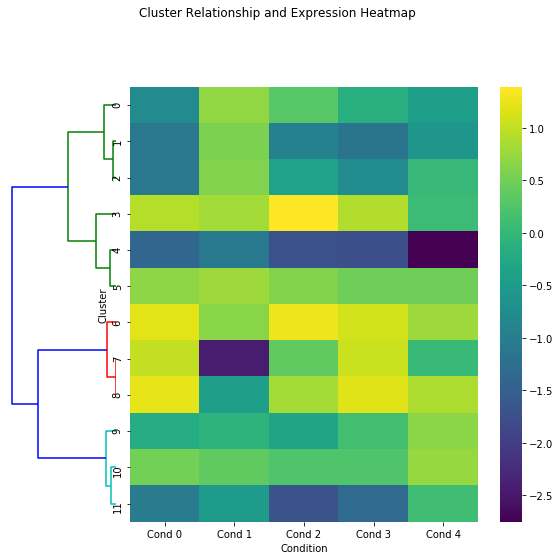

In [76]:

# ---------------------------------------------
# 5. Z-Score and Collapse to Conditions
# ---------------------------------------------
heatmap_matrix = np.array(heatmap_matrix)
heatmap_z = scipy.stats.zscore(heatmap_matrix, axis=0)

collapsed = []
for r in range(0, heatmap_z.shape[1], 4):
    collapsed.append(np.mean(heatmap_z[:, r:r+4], axis=1))
cluster_profiles = np.array(collapsed).T  # shape: (clusters × conditions)



# ---------------------------------------------
# 6. Dendrogram + Heatmap Combined
# ---------------------------------------------
distance_matrix = pdist(cluster_profiles, metric='correlation')
linkage_matrix = linkage(distance_matrix, method='ward')
cluster_order = dendrogram(linkage_matrix, no_plot=True)['leaves']
cluster_profiles_ordered = cluster_profiles[cluster_order, :]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 4], wspace=0.05)

# Dendrogram
ax0 = fig.add_subplot(gs[0])
dendrogram(linkage_matrix, orientation='left', ax=ax0)
ax0.invert_yaxis()
ax0.axis('off')

# Heatmap
ax1 = fig.add_subplot(gs[1])
sns.heatmap(cluster_profiles_ordered, cmap='viridis', cbar=True, xticklabels=[f"Cond {i}" for i in range(5)])
ax1.set_ylabel("Cluster")
ax1.set_xlabel("Condition")

plt.suptitle("Cluster Relationship and Expression Heatmap", y=1.02)
plt.tight_layout()
plt.show()

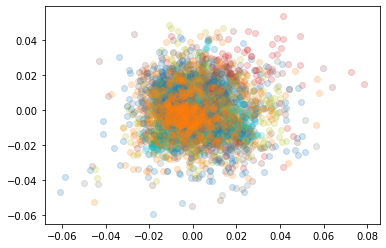

In [98]:
# ---------------------------------------------
# 7. Factors of the PCA in each clusters
# ---------------------------------------------

cluster = clustered_df["Cluster"].values
plt.figure()
for i in range(n_clusters):
    plt.plot(pca.components_[0,cluster==i],pca.components_[1,cluster==i],'o',alpha=0.2)
plt.xlabel('factors PCA 1')
plt.ylabel('factors PCA 2')
plt.show()

ens_gene
FBgn0029843    False
FBgn0026238    False
FBgn0035235    False
FBgn0033669    False
FBgn0032171    False
               ...  
FBgn0001099    False
FBgn0085434    False
FBgn0038358    False
FBgn0030989    False
FBgn0030673    False
Name: Cluster, Length: 13439, dtype: bool